In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import math
import gc
import requests
import reverse_geocoder as rg

In [23]:
riders = pd.read_csv("Riders.csv", index_col = 'Rider Id')
train = pd.read_csv('Train.csv', index_col='Order No')
test = pd.read_csv('Test.csv', index_col='Order No')

In [24]:
y_train = train['Time from Pickup to Arrival'].values
train.drop(["Arrival at Destination - Day of Month","Arrival at Destination - Weekday (Mo = 1)","Arrival at Destination - Time"],axis = 1,inplace =True)

##START coding rider meta data
avg_rating = []
no_ratings = []
days_worked = []
orders = []
rid = train['Rider Id'].values 
for x in rid:
    avg_rating.append(riders.at[x, 'Average_Rating']) #creates a list of average rider rating
    no_ratings.append(riders.at[x, 'No_of_Ratings']) #creates a list of total numbe rof rider ratings
    days_worked.append(riders.at[x, 'Age']) #creates a list of rider age (Days delivering)
    
train['Average Rating'] = avg_rating
train['Age'] = days_worked
train['No. of Ratings'] = no_ratings
##END coding rider meta data
train.pop('Temperature')
##START coding time hours (24hr period)
holder = []
time_binary = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time']
for x in train[time_binary]:
    holder = pd.to_datetime(train[x]).dt.hour
    train[x] = holder
##END coding time hours (24hr period)


##START reverse geocoding
#Creating PICK_UP name DF
pick_up_la = train['Pickup Lat'].values 
pick_up_lo = train['Pickup Long'].values

pic_dest = pd.DataFrame(np.concatenate((pick_up_la.reshape(len(pick_up_la),1), pick_up_lo.reshape(len(pick_up_lo),1)),1))
pic_dest['GPS'] = pic_dest.apply(tuple, axis=1) #Create useable search tuple

pick_up = pic_dest['GPS'].values
searcher_pic = rg.search(list(pick_up))
pick_df = pd.DataFrame(searcher_pic) #final frame with PICK_UP LOC


#Creating DESTINATION name DF

dest_la = train['Destination Lat'].values 
dest_lo = train['Destination Long'].values

del_dest = pd.DataFrame(np.concatenate((dest_la.reshape(len(dest_la),1), dest_lo.reshape(len(dest_lo),1)),1))
del_dest['GPS'] = del_dest.apply(tuple, axis=1) #Create useable search tuple

deliveries = del_dest['GPS'].values
searcher_del = rg.search(list(deliveries))
dest_df = pd.DataFrame(searcher_del) #final frame with DEST LOC

train['Destination'] = dest_df['admin1'].values
train['Pick_up'] = pick_df['admin1'].values
## END reverse geocoding


##STAR df features to be removed
train.pop('Time from Pickup to Arrival')
train.pop('User Id')
train.pop('Placement - Day of Month')
train.pop('Confirmation - Day of Month')
train.pop('Arrival at Pickup - Day of Month')
train.pop('Pickup - Day of Month')
train.pop('Personal or Business')
train.pop('Pickup Lat')
train.pop('Pickup Long')
train.pop('Destination Lat')
train.pop('Destination Long')
train.pop('Rider Id')
train.pop('Precipitation in millimeters')
train.pop('Pickup - Weekday (Mo = 1)')
train.pop('Placement - Weekday (Mo = 1)')
##END df features to be removed
train.pop('Destination')
train.pop('Vehicle Type')
train.pop('Pick_up')
'''
##START encoding dummy variables
catFeatures = ['Vehicle Type', 'Destination', 'Pick_up']
train = pd.get_dummies(train, columns=catFeatures, drop_first = True)
##END encoding dummy variables
'''
x_train = train.values


In [16]:
train.columns

Index(['Platform Type', 'Placement - Time', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Weekday (Mo = 1)',
       'Arrival at Pickup - Time', 'Pickup - Time', 'Distance (KM)',
       'Average Rating', 'Age', 'No. of Ratings'],
      dtype='object')

In [580]:
test.columns

Index(['Platform Type', 'Placement - Time', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Weekday (Mo = 1)',
       'Arrival at Pickup - Time', 'Pickup - Time', 'Distance (KM)',
       'Average Rating', 'Age', 'No. of Ratings', 'Destination_Kiambu',
       'Destination_Machakos', 'Destination_Nairobi Area', 'Pick_up_Kiambu',
       'Pick_up_Machakos', 'Pick_up_Nairobi Area'],
      dtype='object')

In [ ]:
train.head()

In [47]:
train.shape

(21201, 11)

In [17]:
dataset = train[['Platform Type', 'Placement - Time', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Weekday (Mo = 1)',
       'Arrival at Pickup - Time', 'Pickup - Time', 'Distance (KM)',
       'Average Rating', 'Age', 'No. of Ratings']]

In [18]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Platform Type,21201.0,2.752182,0.625178,1.0,3.0,3.0,3.0,4.0
Placement - Time,21201.0,12.326824,2.541007,0.0,10.0,12.0,14.0,22.0
Confirmation - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.0,2.0,3.0,5.0,7.0
Confirmation - Time,21201.0,12.447998,2.556059,0.0,10.0,12.0,14.0,22.0
Arrival at Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.0,2.0,3.0,5.0,7.0
Arrival at Pickup - Time,21201.0,12.663223,2.558333,0.0,11.0,13.0,15.0,23.0
Pickup - Time,21201.0,12.873214,2.551666,0.0,11.0,13.0,15.0,23.0
Distance (KM),21201.0,9.506533,5.668963,1.0,5.0,8.0,13.0,49.0
Average Rating,21201.0,13.882520,0.916071,0.0,13.6,14.0,14.3,15.2
Age,21201.0,984.742842,646.652835,96.0,495.0,872.0,1236.0,3764.0


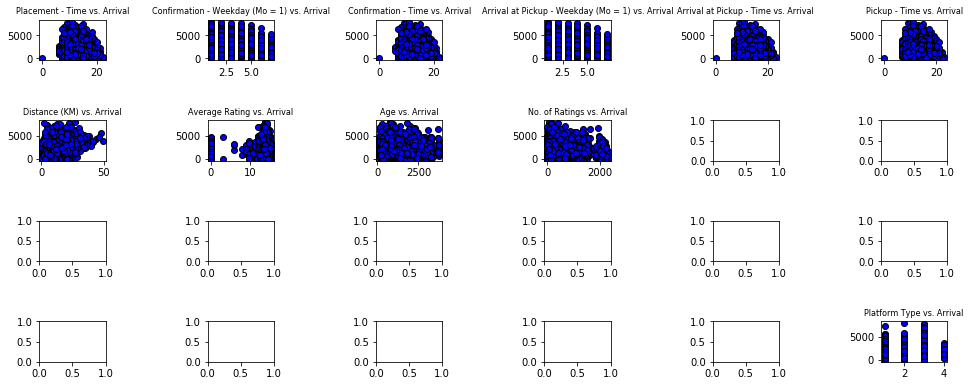

In [19]:
fig, axs = plt.subplots(4,6, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()

for index, column in enumerate(dataset.columns):
    axs[index-1].set_title("{} vs. Arrival".format(column),fontsize=8)
    axs[index-1].scatter(x=dataset[column],y=y_train,color='blue',edgecolor='k')

fig.tight_layout(pad=3)

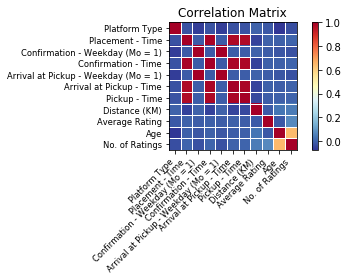

In [20]:
from statsmodels.graphics.correlation import plot_corr
corr = dataset.corr()
fig=plot_corr(corr,xnames=corr.columns)

In [538]:
train.head(15)

,Platform Type,Placement - Time,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Time,Distance (KM),Average Rating,Age,No. of Ratings,Destination_Kiambu,Destination_Machakos,Destination_Nairobi Area,Pick_up_Kiambu,Pick_up_Machakos,Pick_up_Nairobi Area
Order No,,,,,,,,,,,,,,,,,
Order_No_4211,3,9,5,9,5,10,10,4,13.8,1309,549,0,0,1,0,0,1
Order_No_25375,3,11,5,11,5,11,11,16,13.6,339,69,0,0,1,0,0,1
Order_No_1899,3,12,2,12,2,12,12,3,12.5,242,114,0,0,1,0,0,1
Order_No_9336,3,9,5,9,5,9,9,9,14.5,283,113,0,0,1,0,0,1
Order_No_27883,1,9,1,9,1,10,10,9,14.1,872,533,0,0,1,0,0,1
Order_No_7408,3,15,5,15,5,15,15,9,14.2,1204,1056,0,0,1,0,0,1
Order_No_22680,3,9,5,9,5,9,9,5,13.7,556,27,0,0,1,0,0,1
Order_No_21578,3,14,1,14,1,14,14,3,14.4,2119,700,0,0,1,0,0,1
Order_No_5234,3,11,2,11,2,12,12,9,15.0,237,14,0,0,1,0,0,1


In [ ]:
dest_df.head(15)

In [45]:
##START coding time hours (24hr period)
holder2 = []
time_binary2 = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time']
for x in test[time_binary2]:
    holder2 = pd.to_datetime(test[x]).dt.hour
    test[x] = holder2
##END coding time hours (24hr period)

##START coding rider meta data
avg_rating2 = []
no_ratings2 = []
days_worked2 = []
rid2 = test['Rider Id'].values 
for x in rid2:
    avg_rating2.append(riders.at[x, 'Average_Rating']) #creates a list of average rider rating
    no_ratings2.append(riders.at[x, 'No_of_Ratings']) #creates a list of total numbe rof rider ratings
    days_worked2.append(riders.at[x, 'Age']) #creates a list of rider age (Days delivering)

test['Average Rating'] = avg_rating2
test['Age'] = days_worked2
test['No. of Ratings'] = no_ratings2
##END coding rider meta data


##START reverse geocoding
#Creating PICK_UP name DF
pick_up_la_test = test['Pickup Lat'].values 
pick_up_lo_test = test['Pickup Long'].values

pic_dest_test = pd.DataFrame(np.concatenate((pick_up_la_test.reshape(len(pick_up_la_test),1), pick_up_lo_test.reshape(len(pick_up_lo_test),1)),1))
pic_dest_test['GPS'] = pic_dest_test.apply(tuple, axis=1) #Create useable search tuple

pick_up_test = pic_dest_test['GPS'].values
searcher_pic_test = rg.search(list(pick_up_test))
pick_df_test = pd.DataFrame(searcher_pic_test) #final frame with PICK_UP LOC


#Creating DESTINATION name DF
dest_la_test = test['Destination Lat'].values 
dest_lo_test = test['Destination Long'].values

del_dest_test = pd.DataFrame(np.concatenate((dest_la_test.reshape(len(dest_la_test),1), dest_lo_test.reshape(len(dest_lo_test),1)),1))
del_dest_test['GPS'] = del_dest_test.apply(tuple, axis=1) #Create useable search tuple

deliveries_test = del_dest_test['GPS'].values
searcher_del_test = rg.search(list(deliveries_test))
dest_df_test = pd.DataFrame(searcher_del_test) #final frame with DEST LOC
test['Destination'] = dest_df_test['admin1'].values
test['Pick_up'] = pick_df_test['admin1'].values
## END reverse geocoding

test.pop('Temperature')

##START df features to be reomved
test.pop('Placement - Day of Month')
test.pop('Confirmation - Day of Month')
test.pop('Arrival at Pickup - Day of Month')
test.pop('Pickup - Day of Month')
test.pop('Personal or Business')
test.pop('Precipitation in millimeters')
test.pop('User Id')
test.pop('Pickup Lat')
test.pop('Pickup Long')
test.pop('Destination Lat')
test.pop('Destination Long')
test.pop("Rider Id")
test.pop('Pickup - Weekday (Mo = 1)')
test.pop('Placement - Weekday (Mo = 1)')
##END df features to be removed
test.pop('Destination')
test.pop('Vehicle Type')
test.pop('Pick_up')
'''
##START encoding dummy variables 
catFeatures_test = ['Vehicle Type', 'Destination', 'Pick_up']
test = pd.get_dummies(test, columns=catFeatures_test, drop_first = True)
'''
x_test2 = test.values





In [46]:
test.shape

(7068, 11)

In [48]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test2 = sc.fit_transform(x_test2)
x_train

array([[ 0.3964062 , -1.30928492,  1.12288489, ..., -0.09008215,
         0.50145115,  0.51614404],
       [ 0.3964062 , -0.52217695,  1.12288489, ..., -0.30841101,
        -0.99861632, -0.67534207],
       [ 0.3964062 , -0.12862297, -0.79136764, ..., -1.50921972,
        -1.14862306, -0.56364024],
       ...,
       [ 0.3964062 ,  1.83914695,  0.48480071, ..., -0.09008215,
        -0.7913905 , -0.77463257],
       [-2.80275932, -1.30928492, -0.15328346, ...,  0.12824671,
         1.29323933,  1.88635305],
       [ 0.3964062 ,  0.658485  , -0.79136764, ..., -0.30841101,
        -1.08057876, -0.6728598 ]])

In [49]:
# See what still has nan values
for x in train:
    print(x, train[x].isna().mean())

Platform Type 0.0
Placement - Time 0.0
Confirmation - Weekday (Mo = 1) 0.0
Confirmation - Time 0.0
Arrival at Pickup - Weekday (Mo = 1) 0.0
Arrival at Pickup - Time 0.0
Pickup - Time 0.0
Distance (KM) 0.0
Average Rating 0.0
Age 0.0
No. of Ratings 0.0


In [50]:
x_train.shape

(21201, 11)

In [51]:
x_test2.shape

(7068, 11)

In [52]:
from sklearn.model_selection import train_test_split
x_trainer, x_tester, y_trainer, y_tester = train_test_split(x_train, y_train, test_size=0.20)

In [53]:
from catboost import CatBoostRegressor
import catboost
cata = CatBoostRegressor(iterations=600,
                              learning_rate=0.1,
                              depth=10,
                             l2_leaf_reg=10,
                             bootstrap_type='Bernoulli',
                              loss_function = 'RMSE',
                              subsample=0.7,
                              metric_period=20,
                              random_seed=32,
                              allow_writing_files=False)


In [54]:
cata.fit(x_trainer, y_trainer)


0:	learn: 957.8990854	total: 16.2ms	remaining: 9.73s
20:	learn: 789.2155838	total: 258ms	remaining: 7.11s
40:	learn: 767.5456156	total: 555ms	remaining: 7.57s
60:	learn: 757.5697855	total: 839ms	remaining: 7.41s
80:	learn: 748.3260065	total: 1.12s	remaining: 7.17s
100:	learn: 739.7876130	total: 1.41s	remaining: 6.97s
120:	learn: 729.1466001	total: 1.7s	remaining: 6.71s
140:	learn: 720.5482545	total: 1.99s	remaining: 6.48s
160:	learn: 711.6401016	total: 2.31s	remaining: 6.31s
180:	learn: 704.2123821	total: 2.61s	remaining: 6.04s
200:	learn: 695.8354716	total: 2.9s	remaining: 5.76s
220:	learn: 688.9515825	total: 3.22s	remaining: 5.52s
240:	learn: 681.0448002	total: 3.51s	remaining: 5.22s
260:	learn: 673.7616871	total: 3.8s	remaining: 4.93s
280:	learn: 666.7813949	total: 4.1s	remaining: 4.65s
300:	learn: 660.6313755	total: 4.4s	remaining: 4.37s
320:	learn: 654.7941004	total: 4.68s	remaining: 4.07s
340:	learn: 648.9367313	total: 4.98s	remaining: 3.79s
360:	learn: 642.1365507	total: 5.28s	r

In [55]:
from catboost import Pool
feature_score = pd.DataFrame(list(zip(train.dtypes.index, cata.get_feature_importance(Pool(x_train, label=y_train)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

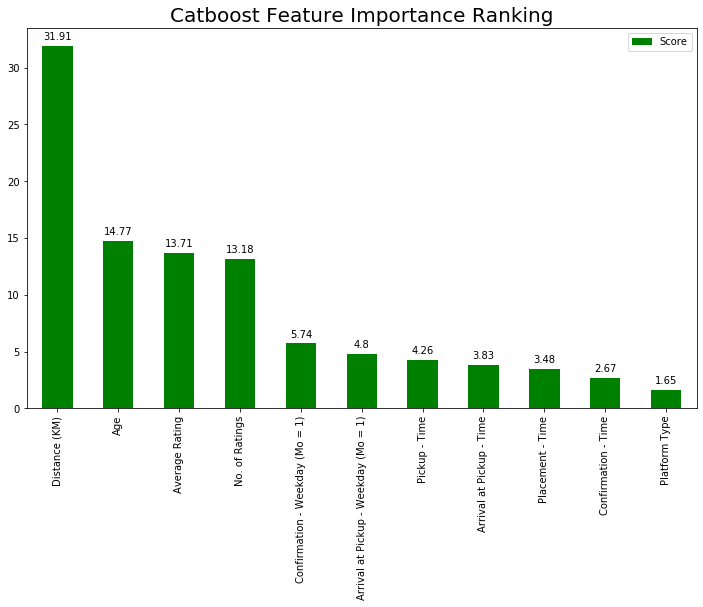

In [56]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='green')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 20)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet

regEN = ElasticNet(alpha=0.00009, tol=0.00001, l1_ratio = 0.9,
                 max_iter=100, normalize = True, random_state=32)
regEN.fit(x_trainer, y_trainer)
cvsEN = cross_val_score(regEN, x_trainer, y_trainer, cv=5)

print(cvsEN)
print(np.mean(cvsEN))

[0.34621067 0.32082492 0.34252671 0.32663867 0.33993679]
0.33522755343427263


In [58]:
from sklearn.linear_model import Lasso

regR = Lasso(tol=0.000001,  max_iter=1000,  random_state=32)
regR.fit(x_trainer, y_trainer)
cvsR = cross_val_score(regEN, x_trainer, y_trainer, cv=100)

print(cvsR)
print(np.mean(cvsR))

[0.33366396 0.42588669 0.3003413  0.2916851  0.36417671 0.44045282
 0.47109867 0.29520418 0.27716662 0.3236606  0.23424456 0.29745215
 0.48058282 0.27501627 0.25145813 0.38274394 0.39211219 0.36090006
 0.34763152 0.32710172 0.35227107 0.3162296  0.30104118 0.33091692
 0.33540416 0.42557103 0.33145033 0.2793575  0.28128894 0.31587753
 0.29537339 0.34320677 0.29132205 0.24705352 0.34785919 0.2770835
 0.32667336 0.36488473 0.2883973  0.27390873 0.29028073 0.30161621
 0.39693362 0.24303895 0.30275019 0.35492106 0.38256504 0.27310364
 0.21128733 0.40602716 0.26145761 0.28991213 0.33920557 0.36695258
 0.30501925 0.43326321 0.2895744  0.39114017 0.42891889 0.36401607
 0.23637758 0.42634937 0.30981758 0.35574667 0.30204182 0.43320473
 0.34061896 0.21506631 0.26485536 0.33673855 0.36068276 0.36574863
 0.40202229 0.28437211 0.4059838  0.30893081 0.21085654 0.23714804
 0.32733386 0.31064044 0.40885264 0.2902097  0.28753325 0.34752432
 0.31107516 0.25929907 0.27705604 0.32854779 0.37856606 0.33446

In [59]:
from sklearn.ensemble import ExtraTreesRegressor

regET = ExtraTreesRegressor(n_estimators = 100, criterion = 'mse', min_weight_fraction_leaf=0.001 , random_state=32, n_jobs=-1)
regET.fit(x_trainer, y_trainer)
cvsET = cross_val_score(regET, x_trainer, y_trainer, cv=10)

print(cvsET)
print(np.mean(cvsET))

[0.37133827 0.36441225 0.36011461 0.3310756  0.33747794 0.37876367
 0.35238329 0.34366201 0.35847409 0.36072345]
0.35584251747354806


In [37]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

models = [("LA",regR),('CA', cata),('ET', regET)]
meta_learner_reg = regEN

s_reg = StackingRegressor(estimators=models, final_estimator=meta_learner_reg, passthrough = True)
s_reg.fit(x_trainer, y_trainer)
s_cvs = cross_val_score(s_reg, x_trainer, y_trainer, cv=5)

print(s_cvs)
print(np.mean(s_cvs))

0:	learn: 960.0821719	total: 16.1ms	remaining: 9.62s
20:	learn: 790.0413606	total: 272ms	remaining: 7.49s
40:	learn: 769.1865608	total: 552ms	remaining: 7.52s
60:	learn: 756.8215166	total: 831ms	remaining: 7.35s
80:	learn: 748.3851907	total: 1.1s	remaining: 7.08s
100:	learn: 740.1112956	total: 1.39s	remaining: 6.85s
120:	learn: 730.5437406	total: 1.66s	remaining: 6.56s
140:	learn: 720.2057692	total: 1.94s	remaining: 6.33s
160:	learn: 711.3499663	total: 2.23s	remaining: 6.07s
180:	learn: 702.5754168	total: 2.5s	remaining: 5.8s
200:	learn: 694.3961757	total: 2.79s	remaining: 5.54s
220:	learn: 686.8133273	total: 3.07s	remaining: 5.27s
240:	learn: 679.4502516	total: 3.35s	remaining: 4.99s
260:	learn: 672.5230981	total: 3.64s	remaining: 4.72s
280:	learn: 664.1208801	total: 3.93s	remaining: 4.46s
300:	learn: 657.5565816	total: 4.21s	remaining: 4.19s
320:	learn: 650.5601523	total: 4.5s	remaining: 3.91s
340:	learn: 644.7289531	total: 4.79s	remaining: 3.63s
360:	learn: 638.9099256	total: 5.07s	

580:	learn: 557.3468160	total: 7.93s	remaining: 259ms
599:	learn: 552.4622647	total: 8.19s	remaining: 0us
0:	learn: 960.0642774	total: 14.9ms	remaining: 8.92s
20:	learn: 787.5883723	total: 280ms	remaining: 7.73s
40:	learn: 762.9468145	total: 555ms	remaining: 7.57s
60:	learn: 751.8027463	total: 819ms	remaining: 7.23s
80:	learn: 740.9141809	total: 1.09s	remaining: 7s
100:	learn: 731.2834070	total: 1.36s	remaining: 6.7s
120:	learn: 721.1387533	total: 1.63s	remaining: 6.46s
140:	learn: 709.8499314	total: 1.91s	remaining: 6.21s
160:	learn: 699.9884029	total: 2.18s	remaining: 5.95s
180:	learn: 690.9150492	total: 2.46s	remaining: 5.69s
200:	learn: 682.3296755	total: 2.73s	remaining: 5.43s
220:	learn: 673.2473790	total: 3.01s	remaining: 5.16s
240:	learn: 665.1357463	total: 3.28s	remaining: 4.89s
260:	learn: 657.3396170	total: 3.56s	remaining: 4.62s
280:	learn: 650.0988337	total: 3.83s	remaining: 4.35s
300:	learn: 642.6885289	total: 4.11s	remaining: 4.08s
320:	learn: 635.8562327	total: 4.38s	re

540:	learn: 537.8548537	total: 7.56s	remaining: 824ms
560:	learn: 531.4568363	total: 7.87s	remaining: 547ms
580:	learn: 525.6960347	total: 8.14s	remaining: 266ms
599:	learn: 520.4819407	total: 8.4s	remaining: 0us
0:	learn: 959.0727411	total: 14.9ms	remaining: 8.93s
20:	learn: 788.7360333	total: 272ms	remaining: 7.51s
40:	learn: 763.0981167	total: 544ms	remaining: 7.42s
60:	learn: 748.4102978	total: 816ms	remaining: 7.21s
80:	learn: 737.8592620	total: 1.09s	remaining: 7s
100:	learn: 725.7276236	total: 1.36s	remaining: 6.72s
120:	learn: 711.2353655	total: 1.63s	remaining: 6.46s
140:	learn: 699.3461372	total: 1.91s	remaining: 6.21s
160:	learn: 687.0853210	total: 2.18s	remaining: 5.95s
180:	learn: 676.9645322	total: 2.46s	remaining: 5.69s
200:	learn: 666.9449913	total: 2.73s	remaining: 5.42s
220:	learn: 657.9351338	total: 3s	remaining: 5.15s
240:	learn: 647.9611688	total: 3.28s	remaining: 4.88s
260:	learn: 638.5190536	total: 3.55s	remaining: 4.62s
280:	learn: 631.5447359	total: 3.82s	remai

520:	learn: 554.7353299	total: 7.11s	remaining: 1.08s
540:	learn: 548.4437342	total: 7.37s	remaining: 804ms
560:	learn: 541.9964526	total: 7.64s	remaining: 531ms
580:	learn: 535.2780782	total: 7.92s	remaining: 259ms
599:	learn: 530.3470604	total: 8.17s	remaining: 0us
0:	learn: 961.4030241	total: 15.1ms	remaining: 9.07s
20:	learn: 792.8703647	total: 248ms	remaining: 6.85s
40:	learn: 766.7926947	total: 524ms	remaining: 7.15s
60:	learn: 752.9178556	total: 772ms	remaining: 6.82s
80:	learn: 741.9883892	total: 1.02s	remaining: 6.56s
100:	learn: 729.6018413	total: 1.3s	remaining: 6.4s
120:	learn: 715.9864761	total: 1.57s	remaining: 6.22s
140:	learn: 703.7158526	total: 1.84s	remaining: 5.99s
160:	learn: 693.2290663	total: 2.1s	remaining: 5.74s
180:	learn: 683.2458896	total: 2.38s	remaining: 5.51s
200:	learn: 673.1628185	total: 2.66s	remaining: 5.28s
220:	learn: 662.7588794	total: 2.93s	remaining: 5.02s
240:	learn: 654.6732776	total: 3.2s	remaining: 4.76s
260:	learn: 645.6004481	total: 3.47s	re

500:	learn: 557.3292636	total: 7.11s	remaining: 1.41s
520:	learn: 551.3297901	total: 7.39s	remaining: 1.12s
540:	learn: 544.9816058	total: 7.69s	remaining: 838ms
560:	learn: 538.1450368	total: 7.97s	remaining: 554ms
580:	learn: 532.8116568	total: 8.25s	remaining: 270ms
599:	learn: 527.2456269	total: 8.52s	remaining: 0us
0:	learn: 959.8486083	total: 14.2ms	remaining: 8.5s
20:	learn: 792.7935568	total: 254ms	remaining: 7s
40:	learn: 769.4445560	total: 524ms	remaining: 7.14s
60:	learn: 755.4582205	total: 782ms	remaining: 6.91s
80:	learn: 744.3141150	total: 1.07s	remaining: 6.84s
100:	learn: 731.9744918	total: 1.34s	remaining: 6.64s
120:	learn: 719.3340801	total: 1.62s	remaining: 6.41s
140:	learn: 707.3050234	total: 1.92s	remaining: 6.24s
160:	learn: 696.4666973	total: 2.2s	remaining: 6s
180:	learn: 686.0111952	total: 2.48s	remaining: 5.74s
200:	learn: 676.8442818	total: 2.76s	remaining: 5.48s
220:	learn: 666.8188027	total: 3.05s	remaining: 5.23s
240:	learn: 657.7054355	total: 3.32s	remain

480:	learn: 583.1999377	total: 6.99s	remaining: 1.73s
500:	learn: 577.5061459	total: 7.26s	remaining: 1.44s
520:	learn: 572.6028315	total: 7.55s	remaining: 1.14s
540:	learn: 567.4848765	total: 7.84s	remaining: 855ms
560:	learn: 562.0938934	total: 8.12s	remaining: 565ms
580:	learn: 557.3468160	total: 8.4s	remaining: 275ms
599:	learn: 552.4622647	total: 8.68s	remaining: 0us
0:	learn: 951.9745694	total: 15.1ms	remaining: 9.05s
20:	learn: 784.9709602	total: 271ms	remaining: 7.47s
40:	learn: 759.3678068	total: 535ms	remaining: 7.29s
60:	learn: 745.1584211	total: 797ms	remaining: 7.04s
80:	learn: 733.6454413	total: 1.06s	remaining: 6.79s
100:	learn: 721.1429222	total: 1.34s	remaining: 6.64s
120:	learn: 707.7772431	total: 1.62s	remaining: 6.4s
140:	learn: 694.4705324	total: 1.89s	remaining: 6.14s
160:	learn: 684.1528910	total: 2.16s	remaining: 5.9s
180:	learn: 673.8072916	total: 2.45s	remaining: 5.68s
200:	learn: 663.6972532	total: 2.72s	remaining: 5.41s
220:	learn: 653.5266468	total: 2.99s	r

440:	learn: 571.4347495	total: 6.04s	remaining: 2.18s
460:	learn: 564.4479517	total: 6.31s	remaining: 1.9s
480:	learn: 558.2959905	total: 6.6s	remaining: 1.63s
500:	learn: 552.5122930	total: 6.88s	remaining: 1.36s
520:	learn: 545.8787054	total: 7.15s	remaining: 1.08s
540:	learn: 540.4103392	total: 7.42s	remaining: 810ms
560:	learn: 534.8209295	total: 7.71s	remaining: 536ms
580:	learn: 529.0794793	total: 7.98s	remaining: 261ms
599:	learn: 522.9316301	total: 8.24s	remaining: 0us
0:	learn: 960.0642774	total: 14.8ms	remaining: 8.85s
20:	learn: 787.5883723	total: 288ms	remaining: 7.95s
40:	learn: 762.9468145	total: 568ms	remaining: 7.74s
60:	learn: 751.8027463	total: 851ms	remaining: 7.51s
80:	learn: 740.9141809	total: 1.13s	remaining: 7.23s
100:	learn: 731.2834070	total: 1.39s	remaining: 6.88s
120:	learn: 721.1387533	total: 1.68s	remaining: 6.66s
140:	learn: 709.8499314	total: 1.97s	remaining: 6.41s
160:	learn: 699.9884029	total: 2.25s	remaining: 6.12s
180:	learn: 690.9150492	total: 2.52s	

400:	learn: 594.4987902	total: 5.35s	remaining: 2.65s
420:	learn: 587.8223863	total: 5.62s	remaining: 2.39s
440:	learn: 580.5070266	total: 5.89s	remaining: 2.12s
460:	learn: 573.8475818	total: 6.16s	remaining: 1.86s
480:	learn: 566.2160078	total: 6.46s	remaining: 1.6s
500:	learn: 560.1723732	total: 6.74s	remaining: 1.33s
520:	learn: 553.4416879	total: 7s	remaining: 1.06s
540:	learn: 547.5432272	total: 7.28s	remaining: 794ms
560:	learn: 540.7902768	total: 7.56s	remaining: 526ms
580:	learn: 535.0541745	total: 7.83s	remaining: 256ms
599:	learn: 529.8917236	total: 8.08s	remaining: 0us
0:	learn: 956.9285077	total: 15.1ms	remaining: 9.03s
20:	learn: 785.7460112	total: 273ms	remaining: 7.51s
40:	learn: 761.2100613	total: 542ms	remaining: 7.39s
60:	learn: 749.1691754	total: 775ms	remaining: 6.84s
80:	learn: 737.9274490	total: 1.04s	remaining: 6.7s
100:	learn: 723.7376843	total: 1.32s	remaining: 6.54s
120:	learn: 711.4543620	total: 1.59s	remaining: 6.31s
140:	learn: 701.3787690	total: 1.86s	rem

In [73]:
'''
****
*****
******
********
'''
#Super Learner 
y_predS = s_reg.predict(x_test2)

y_predS

array([1551.83958577, 1265.51542736, 1124.78734014, ..., 1628.17605603,
       2511.04409984, 1334.6112865 ])

In [61]:
#Extra Trees 
y_predET = regET.predict(x_tester)

y_predET

array([1823.39908827,  629.23383175,  675.34345149, ...,  564.3689928 ,
       3139.31689299, 1263.85880505])

In [62]:
#RLasso 
y_predR = regR.predict(x_tester)

y_predR

array([1645.24041011,  733.40296406,  779.85324093, ...,  682.21085645,
       2963.43167967, 1144.97824924])

In [63]:
#Elastic Net
y_predEN = regEN.predict(x_tester)

y_predEN

array([1837.94070398,  949.40835496,  882.96720456, ...,  899.00930896,
       2884.65161077, 1303.51493689])

In [64]:
#CatBoost
zoo = cata.predict(x_tester)

zoo

array([2399.32196092,  452.18353241,  501.20929415, ...,  684.26636916,
       2655.43668758, 1823.63001754])

In [74]:
from sklearn import metrics

print('r2 Score:', metrics.r2_score(y_tester, y_predS))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_tester, y_predS))
print('Mean Squared Error:', metrics.mean_squared_error(y_tester, y_predS))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tester, y_predS)))

ValueError: Found input variables with inconsistent numbers of samples: [4241, 7068]

In [75]:
testid = test.index
testid

Index(['Order_No_19248', 'Order_No_12736', 'Order_No_768', 'Order_No_15332',
       'Order_No_21373', 'Order_No_14573', 'Order_No_6731', 'Order_No_18436',
       'Order_No_2288', 'Order_No_9063',
       ...
       'Order_No_25241', 'Order_No_5287', 'Order_No_7712', 'Order_No_294',
       'Order_No_16972', 'Order_No_3612', 'Order_No_7657', 'Order_No_1969',
       'Order_No_10591', 'Order_No_1603'],
      dtype='object', name='Order No', length=7068)

In [76]:
d = {'ID': testid, 'Delivery Time':np.round(y_predS, 0)}
sub = pd.DataFrame(data=d)
sub = sub[['ID', 'Delivery Time']]
sub


,ID,Delivery Time
0,Order_No_19248,1552.0
1,Order_No_12736,1266.0
2,Order_No_768,1125.0
3,Order_No_15332,1429.0
4,Order_No_21373,1220.0
...,...,...
7063,Order_No_3612,1226.0
7064,Order_No_7657,2901.0
7065,Order_No_1969,1628.0
7066,Order_No_10591,2511.0


In [77]:
sub.to_csv("sub_1.csv",index  = False)